# The Packages

In [1]:
import numpy as np
import pandas as pd
import os
import gc
import datetime
import warnings

In [2]:

import statsmodels.api as sm
from datetime import date

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
import tensorflow as tf
import math 
# keras = tf.keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
from tensorflow.keras import losses
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.utils import plot_model

In [5]:
tf.__version__

'2.10.1'

In [6]:
# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set_style("darkgrid")
sns.color_palette("mako", as_cmap=True)
import plotly.express as px


In [7]:
# CONFIGURATIONS
# ------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

# Utility Functions

In [8]:
def plotSeries(time, series, lab,form='-'):
    plt.plot(time, series, form, label=lab)
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.grid(True)

In [9]:
def plotEvaluation(testData, predData, columns):
    testDf = pd.DataFrame(testData, columns = columns)
    predDf = pd.DataFrame(predData, columns = columns)
    plt.figure(figsize=(15,5))
    plt.plot(testDf.Close, label='Real')
    plt.plot(predDf.Close, label='Prediction')

    plt.legend(loc="best")
    #for saving figures
    plt.show()

# The Data

In [10]:
wfc = pd.read_csv('Dataset/WFC Daily1.csv')

In [11]:
wfc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,20.16,20.19,19.00,19.56,10.44,9037000
1,2000-01-04,18.62,18.84,18.00,18.59,9.92,15237200
2,2000-01-05,18.50,18.88,18.03,18.41,9.82,8228200
3,2000-01-06,18.53,19.50,18.47,19.22,10.25,8326800
4,2000-01-07,19.62,19.84,19.28,19.56,10.44,7711200


In [12]:
wfc.Date.dtype

dtype('O')

In [13]:
wfc['Date'] = pd.to_datetime(wfc['Date'])
#wfc.set_index(['Date'],inplace=True)

In [14]:
wfc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,20.16,20.19,19.00,19.56,10.44,9037000
1,2000-01-04,18.62,18.84,18.00,18.59,9.92,15237200
2,2000-01-05,18.50,18.88,18.03,18.41,9.82,8228200
3,2000-01-06,18.53,19.50,18.47,19.22,10.25,8326800
4,2000-01-07,19.62,19.84,19.28,19.56,10.44,7711200


In [15]:
wfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5754 entries, 0 to 5753
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5754 non-null   datetime64[ns]
 1   Open       5754 non-null   float64       
 2   High       5754 non-null   float64       
 3   Low        5754 non-null   float64       
 4   Close      5754 non-null   float64       
 5   Adj Close  5754 non-null   float64       
 6   Volume     5754 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 314.8 KB


In [16]:
wfc.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00
mean,36.38,36.78,35.98,36.38,28.01,24313450.19
std,11.74,11.77,11.73,11.75,12.85,26705062.78
min,8.65,8.94,7.80,8.12,5.76,1774000.00
25%,26.71,27.20,26.25,26.74,18.01,10091200.00
50%,32.65,33.13,32.25,32.64,23.18,17086600.00
75%,47.75,48.19,47.33,47.79,41.58,29145250.00
max,65.89,66.31,65.66,65.93,57.96,478736600.00


In [17]:
correlation = wfc.corr ()  
correlation. style.background_gradient ()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999324,0.999274,0.998754,0.965403,-0.184389
High,0.999324,1.000000,0.998796,0.999323,0.967945,-0.169457
Low,0.999274,0.998796,1.000000,0.999303,0.963519,-0.199335
Close,0.998754,0.999323,0.999303,1.000000,0.966149,-0.183272
Adj Close,0.965403,0.967945,0.963519,0.966149,1.000000,-0.080189
Volume,-0.184389,-0.169457,-0.199335,-0.183272,-0.080189,1.000000


# The Split

In [18]:
min_date = wfc.Date.min()
max_date = wfc.Date.max()
print("Min:", min_date, "Max:", max_date)

Min: 2000-01-03 00:00:00 Max: 2022-11-11 00:00:00


In [19]:
train_percent = .75
valid_percent = .12

time_between = max_date - min_date

train_cutoff = min_date + train_percent*time_between
valid_cutoff = min_date + (train_percent + valid_percent)*time_between

print("Training Cutoff Date: {:s}".format(str(train_cutoff)))
print("Validation Cutoff Date: {:s}".format(str(valid_cutoff)))

Training Cutoff Date: 2017-02-23 00:00:00
Validation Cutoff Date: 2019-11-21 18:14:24


In [20]:
train_df = wfc[wfc.Date <= train_cutoff]
valid_df = wfc[(wfc.Date > train_cutoff) & (wfc.Date <= valid_cutoff)]
test_df = wfc[wfc.Date > valid_cutoff]


In [21]:
print("Dataset shape: {:s}".format(str(wfc.shape)))
print("Train dataset shape: {:s}".format(str(train_df.shape)))
print("Vaid dataset shape: {:s}".format(str(valid_df.shape)))
print("Test dataset shape: {:s}".format(str(test_df.shape)))

Dataset shape: (5754, 7)
Train dataset shape: (4313, 7)
Vaid dataset shape: (692, 7)
Test dataset shape: (749, 7)


# Stock Price Graph

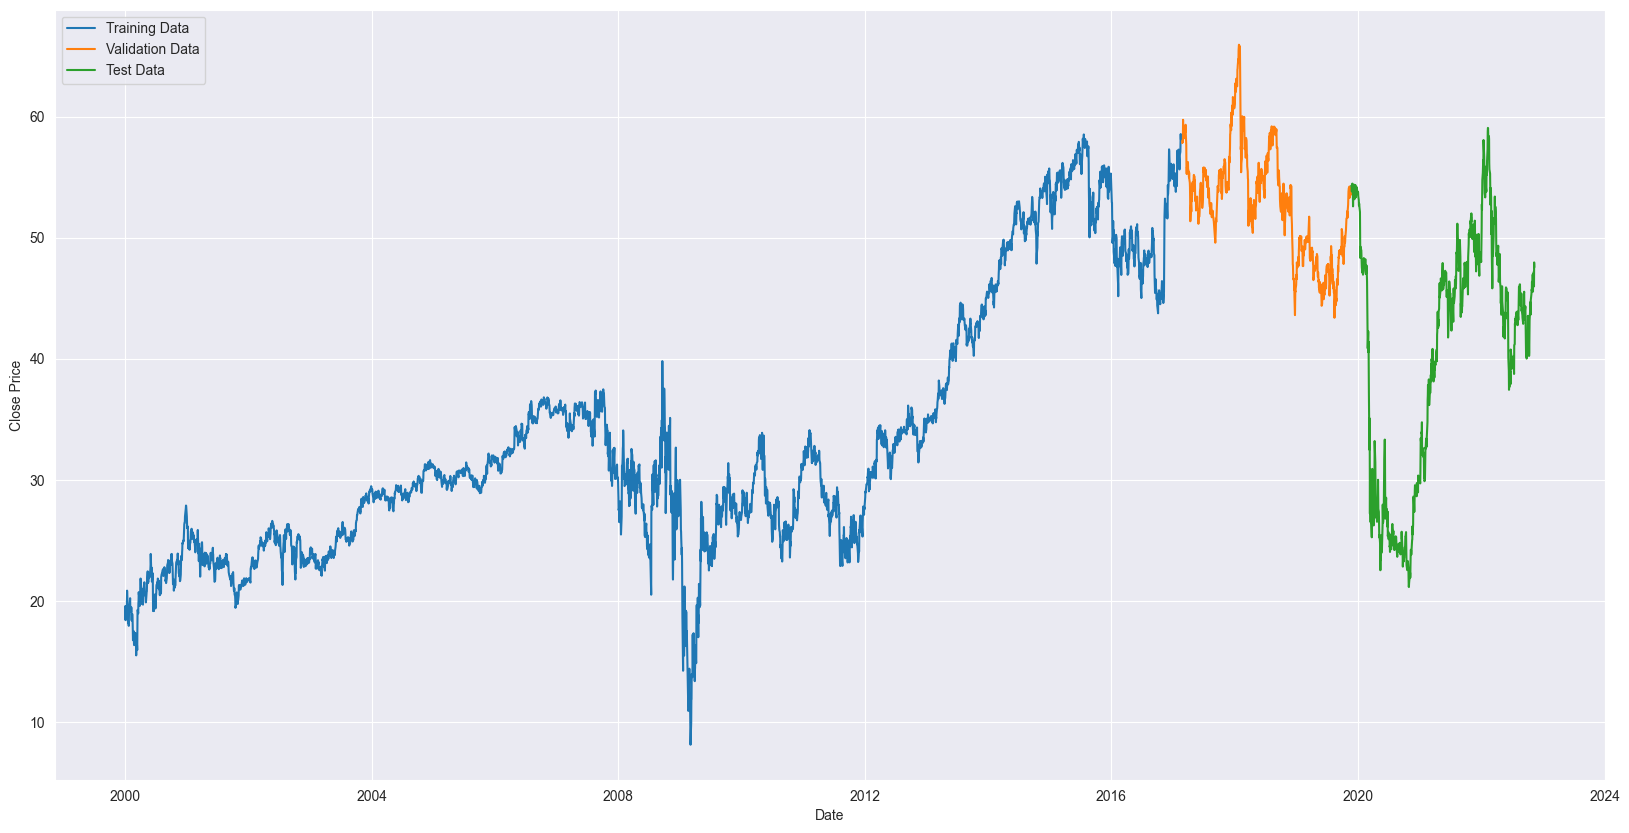

In [22]:
plotSeries(train_df.Date, train_df.Close, "Training Data")
plotSeries(valid_df.Date, valid_df.Close, "Validation Data")
plotSeries(test_df.Date, test_df.Close, "Test Data")
plt.legend(loc='upper left')

In [23]:
train_df.set_index(['Date'],inplace=True)
test_df.set_index(['Date'],inplace=True)
valid_df.set_index(['Date'],inplace=True)

In [24]:
scaler = MinMaxScaler()

trainNorm = scaler.fit_transform(train_df.values)
testNorm = scaler.transform(test_df.values)
validNorm = scaler.transform(valid_df.values)

trainNormDf = pd.DataFrame(trainNorm, columns=train_df.columns)
testNormDf = pd.DataFrame(testNorm, columns=test_df.columns)
validNormDf = pd.DataFrame(validNorm, columns=valid_df.columns)


In [25]:
def splitSequence(sequence, look_back, forecast_horizon):
    X, y = list(), list()
    for i in range(len(sequence)): 
        lag_end = i + look_back
        forecast_end = lag_end + forecast_horizon
        if forecast_end > len(sequence):
            break
        seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [26]:
LOOK_BACK = 24
FORECAST_RANGE = 4
n_features = len(trainNormDf.columns)

In [27]:
#Add valid df
X_train, y_train = splitSequence(trainNormDf, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test, y_test = splitSequence(testNormDf, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)

In [28]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4286, 24, 6)
(4286, 4, 6)
(722, 24, 6)
(722, 4, 6)


In [29]:
def inverse_transform(y_test, yhat):
    y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
    yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
    yhat_inverse = scaler.inverse_transform(yhat_reshaped)
    y_test_inverse = scaler.inverse_transform(y_test_reshaped)
    return yhat_inverse, y_test_inverse

In [30]:
def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse,yhat_inverse)
    print('mae:', mae)
    mse = mse_(y_test_inverse,yhat_inverse)
    print('mse:', mse)
    mape = mape_(y_test_inverse,yhat_inverse)
    print('mape:', mape)

In [31]:
mse_ = tf.keras.losses.MeanSquaredError()
mae_ = tf.keras.losses.MeanAbsoluteError()
mape_ = tf.keras.losses.MeanAbsolutePercentageError()
# mae = mae_(y_test_inverse,yhat_inverse)
# # print('mae:', mae)
# mse = mse_(y_test_inverse,yhat_inverse)
# # print('mse:', mse)
# mape = mape_(y_test_inverse,yhat_inverse)
# # print('mape:', mape)

In [32]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Encoder Decoder Model

In [33]:
tf.keras.backend.clear_session()
model_enc_dec = tf.keras.Sequential()

In [34]:
# WARNING:tensorflow:Layer lstm will not use cuDNN kernels since
# it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
model_enc_dec.add(LSTM(100, input_shape=(LOOK_BACK, n_features)))
model_enc_dec.add(RepeatVector(FORECAST_RANGE))
model_enc_dec.add(LSTM(100, return_sequences=True))
model_enc_dec.add(TimeDistributed(Dense(n_features)))
model_enc_dec.compile(optimizer='adam', loss='mse')

In [35]:
# plot_model(model=model_enc_dec, show_shapes=True)

In [36]:
checkpoint_filepath = ''
# checkpoint_callback = ModelCheckpoint(
#  filepath=checkpoint_filepath,
#  save_weights_only=False,
#  monitor='val_loss',
#  mode='min',
#  save_best_only=True)
early_stopping_callback = EarlyStopping(
 monitor='val_loss',
 min_delta=0.005,
 patience=10,
 mode='min'
)
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, mode='min', patience=3, min_lr=0.001)

In [37]:
epochs = 50
batch_size = 32
validation = 0.1

In [38]:
history = model_enc_dec.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation, \
                            callbacks=[early_stopping_callback, rlrop_callback])

Epoch 1/50
121/121 [==============================] - 14s 24ms/step - loss: 0.0130 - val_loss: 0.0020 - lr: 0.0010
Epoch 2/50
121/121 [==============================] - 2s 13ms/step - loss: 8.5439e-04 - val_loss: 0.0017 - lr: 0.0010
Epoch 3/50
121/121 [==============================] - 2s 13ms/step - loss: 7.9217e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 4/50
121/121 [==============================] - 2s 13ms/step - loss: 7.2729e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 5/50
121/121 [==============================] - 2s 13ms/step - loss: 6.2108e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 6/50
121/121 [==============================] - 2s 13ms/step - loss: 6.3808e-04 - val_loss: 0.0019 - lr: 0.0010
Epoch 7/50
121/121 [==============================] - 2s 14ms/step - loss: 6.1575e-04 - val_loss: 9.8692e-04 - lr: 0.0010
Epoch 8/50
121/121 [==============================] - 2s 13ms/step - loss: 5.6209e-04 - val_loss: 7.7613e-04 - lr: 0.0010
Epoch 9/50
121/121 [==============================]

In [39]:
yhat = model_enc_dec.predict(X_test, verbose=0)

In [40]:
predData, testData = inverse_transform(y_test, yhat)
evaluate_forecast(testData, predData)

mae: tf.Tensor(1815971.1, shape=(), dtype=float32)
mse: tf.Tensor(38291865000000.0, shape=(), dtype=float32)
mape: tf.Tensor(10.372225, shape=(), dtype=float32)


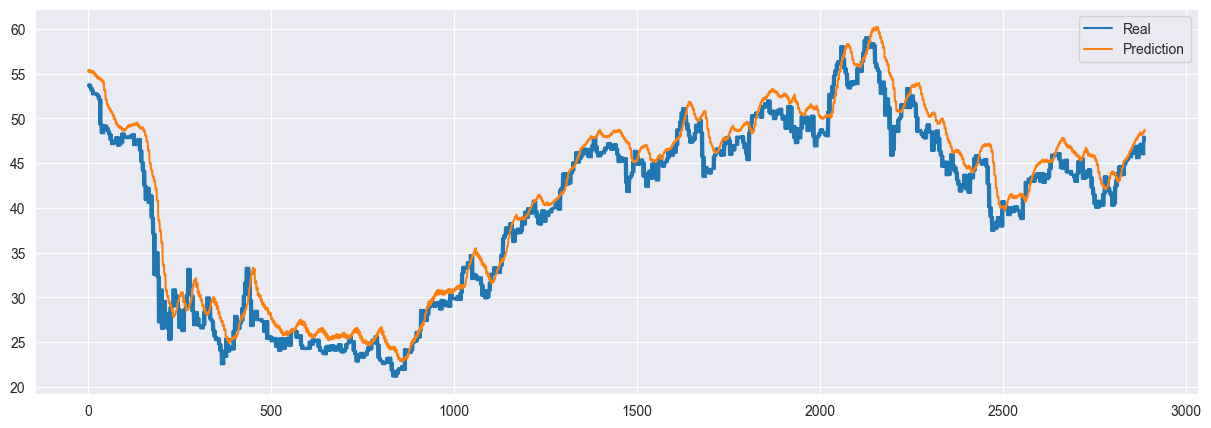

In [41]:
plotEvaluation(testData, predData, columns = testNormDf.columns)

## CNN-LSTM Encoder-Decoder Model

In [42]:
tf.keras.backend.clear_session()
model_enc_dec_cnn = Sequential()

In [43]:

model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(LOOK_BACK, n_features)))
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())
model_enc_dec_cnn.add(RepeatVector(FORECAST_RANGE))
model_enc_dec_cnn.add(LSTM(200, return_sequences=True))
model_enc_dec_cnn.add(TimeDistributed(Dense(100, activation='relu')))
model_enc_dec_cnn.add(TimeDistributed(Dense(n_features)))
model_enc_dec_cnn.compile(loss='mse', optimizer='adam')

In [44]:
history = model_enc_dec_cnn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation, \
                            callbacks=[early_stopping_callback, rlrop_callback])

Epoch 1/50
121/121 [==============================] - 11s 17ms/step - loss: 0.0119 - val_loss: 0.0024 - lr: 0.0010
Epoch 2/50
121/121 [==============================] - 1s 10ms/step - loss: 0.0010 - val_loss: 0.0016 - lr: 0.0010
Epoch 3/50
121/121 [==============================] - 1s 11ms/step - loss: 8.7123e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 4/50
121/121 [==============================] - 1s 10ms/step - loss: 7.8014e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 5/50
121/121 [==============================] - 1s 10ms/step - loss: 7.9327e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 6/50
121/121 [==============================] - 1s 11ms/step - loss: 7.2444e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 7/50
121/121 [==============================] - 1s 10ms/step - loss: 6.8537e-04 - val_loss: 0.0025 - lr: 0.0010
Epoch 8/50
121/121 [==============================] - 1s 11ms/step - loss: 7.1011e-04 - val_loss: 9.7043e-04 - lr: 0.0010
Epoch 9/50
121/121 [==============================] - 1s 10

In [45]:
yhat = model_enc_dec_cnn.predict(X_test, verbose=0)

In [46]:
predData, testData = inverse_transform(y_test, yhat)
evaluate_forecast(testData, predData)

mae: tf.Tensor(2137569.2, shape=(), dtype=float32)
mse: tf.Tensor(50307120000000.0, shape=(), dtype=float32)
mape: tf.Tensor(12.097248, shape=(), dtype=float32)


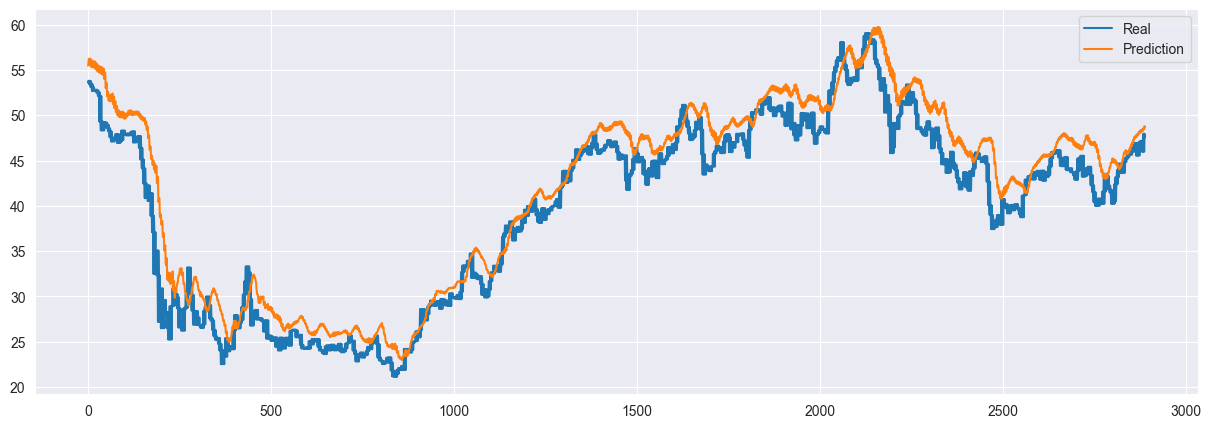

In [47]:
plotEvaluation(testData, predData, columns = testNormDf.columns)

## Model Vector Output

In [48]:
input_layer = Input(shape=(LOOK_BACK, n_features)) 
conv = Conv1D(filters=4, kernel_size=7, activation='relu')(input_layer)
conv = Conv1D(filters=6, kernel_size=11, activation='relu')(conv)
lstm = LSTM(100, return_sequences=True)(conv)
dropout = Dropout(0.2)(lstm)
lstm = LSTM(100)(dropout)
dense = Dense(FORECAST_RANGE*n_features, activation='relu')(lstm)
output_layer = Reshape((FORECAST_RANGE,n_features))(dense)
model_vector_output = Model([input_layer], [output_layer])
model_vector_output.compile(optimizer='adam', loss='mse')

In [49]:
history = model_vector_output.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation, \
                            callbacks=[early_stopping_callback, rlrop_callback])

Epoch 1/50
121/121 [==============================] - 7s 22ms/step - loss: 0.0233 - val_loss: 0.0343 - lr: 0.0010
Epoch 2/50
121/121 [==============================] - 1s 11ms/step - loss: 0.0083 - val_loss: 0.0043 - lr: 0.0010
Epoch 3/50
121/121 [==============================] - 1s 12ms/step - loss: 0.0024 - val_loss: 0.0030 - lr: 0.0010
Epoch 4/50
121/121 [==============================] - 1s 12ms/step - loss: 0.0021 - val_loss: 0.0025 - lr: 0.0010
Epoch 5/50
121/121 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.0019 - lr: 0.0010
Epoch 6/50
121/121 [==============================] - 2s 13ms/step - loss: 0.0018 - val_loss: 0.0023 - lr: 0.0010
Epoch 7/50
121/121 [==============================] - 2s 14ms/step - loss: 0.0018 - val_loss: 0.0018 - lr: 0.0010
Epoch 8/50
121/121 [==============================] - 2s 15ms/step - loss: 0.0017 - val_loss: 0.0018 - lr: 0.0010
Epoch 9/50
121/121 [==============================] - 2s 14ms/step - loss: 0.0017 - val_

In [50]:
yhat = model_vector_output.predict(X_test, verbose=0)

In [51]:
predData, testData = inverse_transform(y_test, yhat)
evaluate_forecast(testData, predData)

mae: tf.Tensor(5728395.0, shape=(), dtype=float32)
mse: tf.Tensor(250239090000000.0, shape=(), dtype=float32)
mape: tf.Tensor(25.481884, shape=(), dtype=float32)


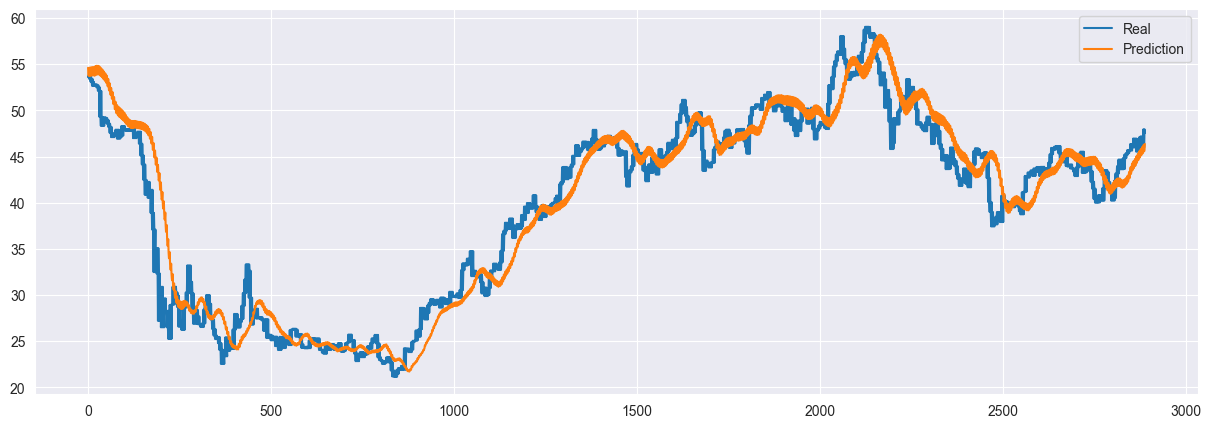

In [52]:
plotEvaluation(testData, predData, columns = testNormDf.columns)

## Multihead CNN LSTM Model

In [53]:
input_layer = Input(shape=(LOOK_BACK, n_features)) 
head_list = []
for i in range(0, n_features):
    conv_layer_head = Conv1D(filters=4, kernel_size=7, activation='relu')(input_layer)
    conv_layer_head_2 = Conv1D(filters=6, kernel_size=11, activation='relu')(conv_layer_head)
    conv_layer_flatten = Flatten()(conv_layer_head_2)
    head_list.append(conv_layer_flatten)

concat_cnn = Concatenate(axis=1)(head_list)
reshape = Reshape((head_list[0].shape[1], n_features))(concat_cnn)
lstm = LSTM(100)(reshape)
repeat = RepeatVector(FORECAST_RANGE)(lstm)
lstm_2 = LSTM(100, return_sequences=True)(repeat)
dropout = Dropout(0.2)(lstm_2)
dense = Dense(n_features, activation='linear')(dropout)
multi_head_cnn_lstm_model = Model(inputs=input_layer, outputs=dense)
multi_head_cnn_lstm_model.compile(optimizer='adam', loss='mse')

In [54]:
history = multi_head_cnn_lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation, \
                            callbacks=[early_stopping_callback, rlrop_callback])

Epoch 1/50
121/121 [==============================] - 9s 32ms/step - loss: 0.0218 - val_loss: 0.0029 - lr: 0.0010
Epoch 2/50
121/121 [==============================] - 3s 23ms/step - loss: 0.0034 - val_loss: 0.0020 - lr: 0.0010
Epoch 3/50
121/121 [==============================] - 3s 21ms/step - loss: 0.0027 - val_loss: 0.0017 - lr: 0.0010
Epoch 4/50
121/121 [==============================] - 3s 22ms/step - loss: 0.0022 - val_loss: 0.0029 - lr: 0.0010
Epoch 5/50
121/121 [==============================] - 3s 22ms/step - loss: 0.0021 - val_loss: 0.0016 - lr: 0.0010
Epoch 6/50
121/121 [==============================] - 3s 22ms/step - loss: 0.0021 - val_loss: 0.0015 - lr: 0.0010
Epoch 7/50
121/121 [==============================] - 3s 21ms/step - loss: 0.0018 - val_loss: 0.0013 - lr: 0.0010
Epoch 8/50
121/121 [==============================] - 3s 21ms/step - loss: 0.0016 - val_loss: 0.0013 - lr: 0.0010
Epoch 9/50
121/121 [==============================] - 2s 20ms/step - loss: 0.0015 - val_

In [55]:
yhat = multi_head_cnn_lstm_model.predict(X_test, verbose=0)

In [56]:
predData, testData = inverse_transform(y_test, yhat)
evaluate_forecast(testData, predData)

mae: tf.Tensor(2579497.8, shape=(), dtype=float32)
mse: tf.Tensor(54607036000000.0, shape=(), dtype=float32)
mape: tf.Tensor(18.222864, shape=(), dtype=float32)


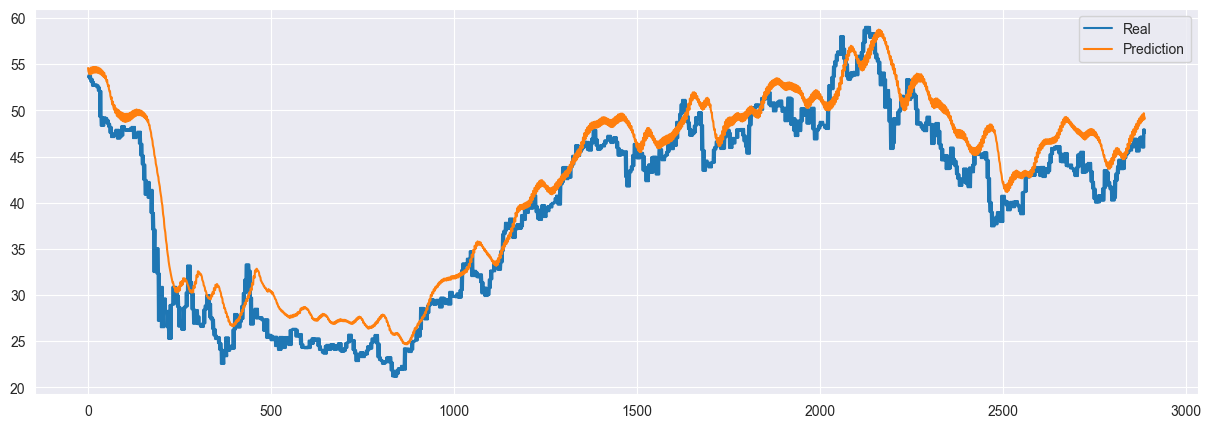

In [57]:
plotEvaluation(testData, predData, columns = testNormDf.columns)

## Ploting The Evaluation

Text(0, 0.5, 'MAPE')

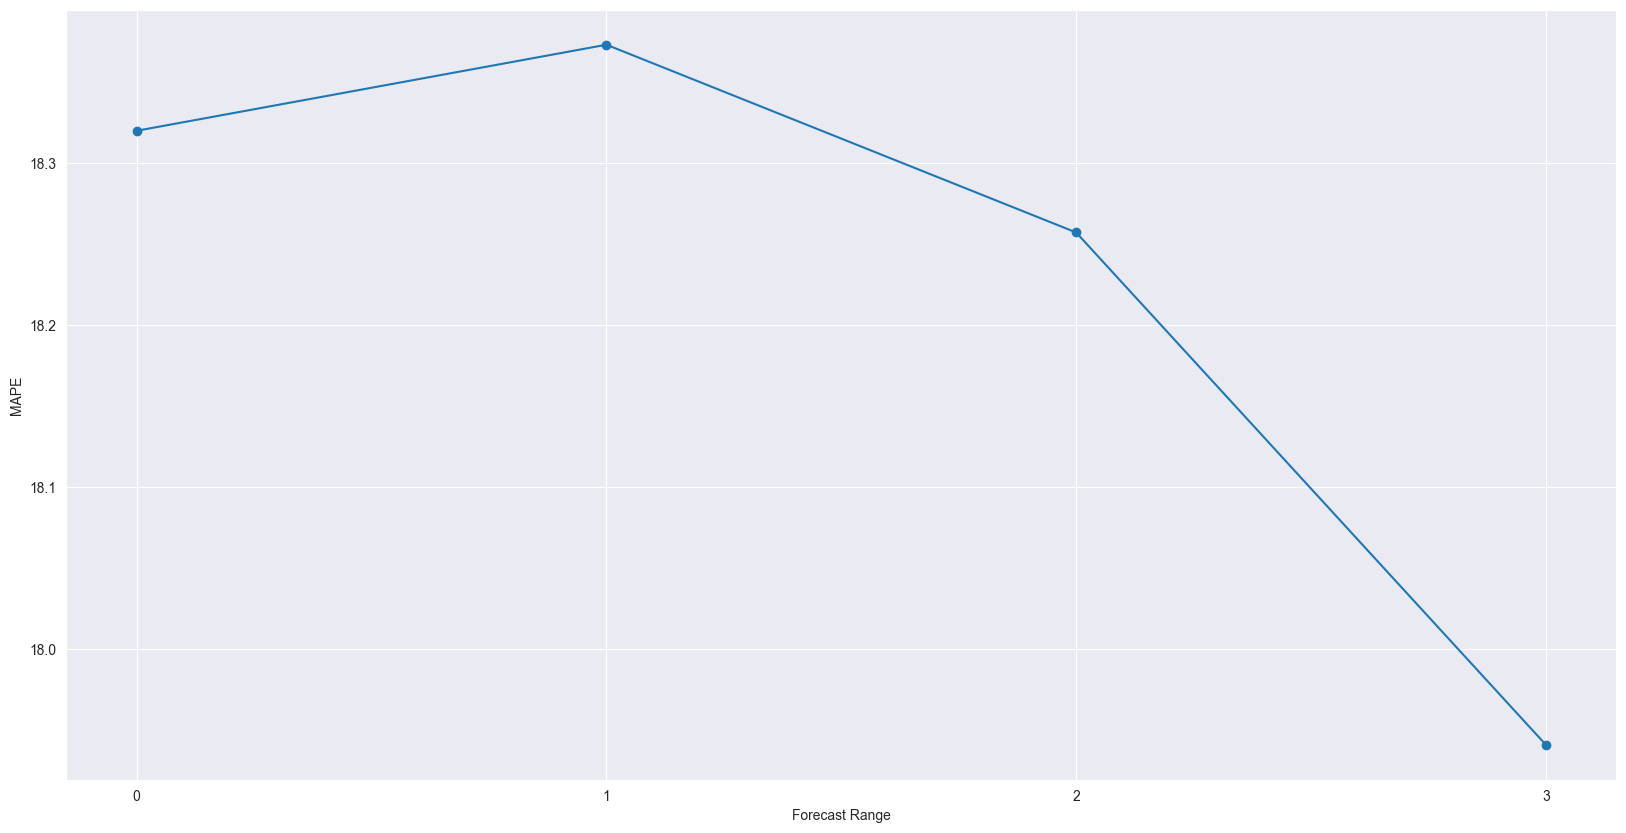

In [58]:
y_test_inverse_time_step  = testData.reshape(int(testData.shape[0]/FORECAST_RANGE), \
                                                  FORECAST_RANGE, testData.shape[-1])
yhat_inverse_time_step = predData.reshape(int(predData.shape[0]/FORECAST_RANGE), \
                                              FORECAST_RANGE, predData.shape[-1])
# yhat_inverse_time_step and y_test_inverse_time_step are both same dimension.
time_step_list_yhat = [[] for i in range(FORECAST_RANGE)]
time_step_list_y_test = [[] for i in range(FORECAST_RANGE)]
for i in range(0, yhat_inverse_time_step.shape[0]):
    for j in range(0, yhat_inverse_time_step.shape[1]):
        time_step_list_yhat[j].append(list(yhat_inverse_time_step[i][j]))
        time_step_list_y_test[j].append(list(y_test_inverse_time_step[i][j]))
yhat_time_step = np.array(time_step_list_yhat)
yhat_time_step = yhat_time_step.reshape(yhat_time_step.shape[0], -1)
y_test_time_step = np.array(time_step_list_y_test)
y_test_time_step = y_test_time_step.reshape(y_test_time_step.shape[0], -1)
# plotting
mape_list = []
for i in range(0, FORECAST_RANGE):
    mape = mape_(y_test_time_step[i], yhat_time_step[i])
    mape_list.append(mape)
plt.plot(range(0, FORECAST_RANGE), mape_list, marker='o')
plt.xticks((range(0, FORECAST_RANGE)))
plt.xlabel('Forecast Range')
plt.ylabel('MAPE')

In [59]:
for i in range(0, n_features):
    print('->', i)
    mae = mae_(y_test_inverse[:,i],yhat_inverse[:,i])
    print('mae:', mae)
    mse = mse_(y_test_inverse[:,i],yhat_inverse[:,i])
    print('mse:', mse)
    mape = mape_(y_test_inverse[:,i],yhat_inverse[:,i])
    print('mape:', mape)

-> 0


NameError: name 'y_test_inverse' is not defined